# Basic Queries on numerical datasets

First off, we are going to test the applicability of the already given IBM diffprivlib mechanisms on a numerical dataset. Our goal is to run basic queries, such as mean value, sum and max elements on the dataset's records.  We are going to do that first by applying no DP at all, and then by applying different kinds of noises generated by a plethora of mechanisms to the data. 

## The identity of the dataset: Surgery Charges Across the U.S.

The dataset contains different kinds of surgeries in a plethora of different hospitals. The information gathered by those combinations, are the average charges of the surgery, which is going to help a potential patient balance his need of top care, and the need to spend less money.

The columns contained are: 
 - __Surgery code and definition__ 
 - __Provider hospital name__
 - __Provider city__
 - __Provider state code__
 - __Average total payments__
 - __Average medicare payments__

## Import libraries

In [1]:
import pandas as pd
import diffprivlib as dp
import numpy as np
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
DATASET = "./surgeries.csv"
df = pd.read_csv(DATASET)

Let's take a look at the dataset info to see if everything is alright.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202655 entries, 0 to 202654
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Surgery Type               202655 non-null  object
 1   Hospital name              202655 non-null  object
 2   Hospital city              202655 non-null  object
 3   Hospital state code        202655 non-null  object
 4   Average Total Payments     202655 non-null  object
 5   Average Medicare Payments  202655 non-null  object
dtypes: object(6)
memory usage: 9.3+ MB


Let's replace the $ sign in the charges so we can take the data as numerical.

In [4]:
df[df.columns[4:5]] = df[df.columns[4:5]].replace('[\$,]', '', regex=True).astype(float)
df[df.columns[5:6]] = df[df.columns[5:6]].replace('[\$,]', '', regex=True).astype(float)

In [5]:
df.head()

,Surgery Type,Hospital name,Hospital city,Hospital state code,Average Total Payments,Average Medicare Payments
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,MAYO CLINIC HOSPITAL,PHOENIX,AZ,240422.80,133509.55
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,SUTTER GENERAL HOSPITAL,SACRAMENTO,CA,233197.48,221681.80
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,RONALD REAGAN U C L A MEDICAL CENTER,LOS ANGELES,CA,415968.79,366608.93
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,STANFORD HOSPITAL,STANFORD,CA,420865.48,403453.65
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,UCSF MEDICAL CENTER,SAN FRANCISCO,CA,378786.95,361565.60


## Setup

### Bounds' definition

We are considering fees for surgeries in our example, thus a logical lower bound would be 0$ (surgeries could be done pro bono too!), and an upper bound would be 1 million dollars.

Either way, we are trying to be extreme with our picks, in order to not find ourselves in the unfortunate situation that a value taken into consideration by the DP query would be out of bounds

In [6]:
total_payment_range = medicare_payment_range = (0, 1000000)

One parameter when applying DP is the __budget accountant__. This variable tracks the privacy spent, so that our system is not left exposed after lots of "expensive queries". The system will allow someone to ask one question that uses the whole privacy budget, or a series of questions whose total impact is less or equal to the initial budget.

The IBM diffprivlib allows us to initialize that, by calling the `set_default` function of the `BudgetAccountant` class. Thus, every time that we'll make a DP call, the budget will be adjusted. 

In [7]:
acc = dp.BudgetAccountant(1, 0)
acc.set_default()

BudgetAccountant(epsilon=1, delta=0)

However, we are going to run many tests on the dataset, thus we are going to unset the acc value for now.

In [8]:
acc.pop_default()

BudgetAccountant(epsilon=1, delta=0)

### Accuracy Testings

In order to measure the accuracy of the queries, we must run them many times. As we know, noise for DP is generated by probabilistic distributions that can take extreme values. So, to be on the safe side, when we want to measure the accuracy of a query, we are going to run it 100 times, and take the mean value of those 100 differences between the DP and the non-DP query.

In [9]:
def accuracy_error(non_dp_query, dp_query, bounds, dataset, epsilon = 1):
    # list of the error in every loop
    acc = []
    # result without dp. No need to re-compute in every loop
    res_wo_dp = non_dp_query(dataset)
    # run 100 times
    for i in range(0,100):
        # result with dp. subject to change in every loop
        res_with_dp = dp_query(dataset, bounds = bounds, epsilon = epsilon)
        # absolute error of the 2 computations
        diff = abs(res_wo_dp - res_with_dp)
        # append the error in the error list
        acc.append(diff)
    # return the mean error of our computations
    return np.mean(acc)

## Basic Queries

We are going to explore the behavior of basic queries in the following manner: We are going to take a small portion of the dataset, and each time increasing it, in order to find the error rate, between the actual result of the query, and the DP approximation. The epsilon value will subject to change during our testings.

### Mean Value

Let's compute the mean value of the total amount need to be spent for a surgery, with and without the use of DP. The IBM's mean uses noise added by the Laplace distribution.

In [10]:
mean_wo_dp = np.mean(df['Average Total Payments'])
print (mean_wo_dp)

13167.382352421602


In [11]:
mean_with_dp = dp.tools.mean(df['Average Total Payments'].tolist())
print (mean_with_dp)

13168.506618238682


/home/nikos/.local/lib/python3.8/site-packages/diffprivlib/tools/utils.py:232: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "


As we can see, the 2 values are extremely close, mostly due to the big size of the dataset.

Let's suppose now, that we have a rather small dataset. What would be the results of the application of DP? What would be the optimal epsilon value that we should choose?

We are going to go through some epsilon values, each time by taking samples of the same dataset. Those samples will begin from small ones, and move on to larger ones. The value that we'll be plotting each time, will be the accuracy of the query, computed by our pre-defined function

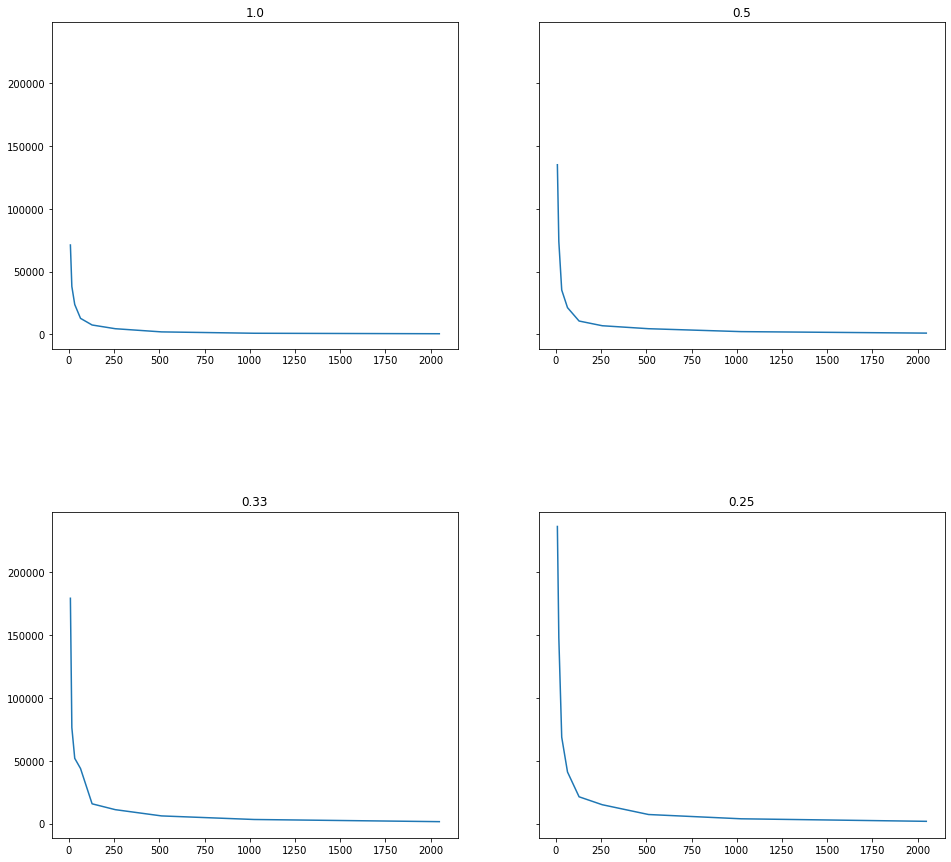

In [12]:
# plot initialization
fig, axs = plt.subplots(2, 2, sharey = True, figsize = (16,15))
fig.subplots_adjust(hspace = 0.5)

# epsilon values that we are going to examine
eps = [1 / i for i in range (1,5)]
# list of the sample sizes that we are going to take
sample_size = [2 ** i for i in range (3,12)]

# loop through the epsilon values
for e in range(0,4):
    # set-up for the graphical representation
    ax = axs.flat[e]
    ax.set_title(round(eps[e],2))
    # list of the error rate that will occur
    error = []
    # loop through the samples list
    for i in sample_size:
        sample_df = df.sample(i)
        # calculate the accuracy produced by those measurements
        res = accuracy_error(np.mean, dp.tools.mean, total_payment_range, sample_df['Average Total Payments'].tolist(), epsilon = eps[e])
        error.append(res)
    # each time plot the varience of the absolute error, as we are enlargening the dataset
    ax.plot(sample_size, error)
    
plt.show()

Facts gathered from the above analysis:
 - The smaller the epsilon gets, the bigger the error in case of small datasets
 - Error stabilizes near 0 as the size of the dataset gets $\leq 800 $

__After the analysis for the mean value query, we come to the conclusion that the value computed using DP, is not very far away from the real one, especially if we are dealing with a rather large dataset. Thus, despite of the trade-off between privacy and accuracy, we can safely say that DP accomplishes its promise when applying a mean value query to a dataset__.

### Variance

Next up, we're going to showcase how the `var` query is used. It is very similar to the `mean`, as well as the numpy `var`.

We are going to try a more complicated query. Let's say we want to find the variance of the surgeries performed in Stanford Hospital.

In [13]:
var = dp.tools.var(df.loc[(df['Hospital name'] == 'STANFORD HOSPITAL')]['Average Medicare Payments'].tolist(), bounds = medicare_payment_range)
print (var)

5657827890.221844


The argue here is whether or not this query is differential private. Python has its own way to preprocess the dataset and take only the data that we are interested in (aka surgeries in Stanford). Then, we pass this smaller dataset in the DP query, and then get a private answer. However, the preprocessing is made in an absolutely non-DP way, which questions the integrity of those simple queries. For example, what will happen if by the preprocessing a set of only 1 element occurs? That definitely violates the definition of DP.

### Sum

A not so important query in our dataset, but essential in the real world is `sum`. Let's see how DP's additional noise effects the query.

We want to find the sum of all the surgery payments that were made in the state of California. Let's see what we get with, and without DP.

In [14]:
sum_wo_dp = np.sum(df.loc[(df['Hospital state code'] == 'CA')]['Average Total Payments'].tolist())
sum_with_dp = dp.tools.sum(df.loc[(df['Hospital state code'] == 'CA')]['Average Total Payments'].tolist(), bounds = total_payment_range)
print("Regular sum: {:.2f}. \nSum with DP: {:.2f}".format(sum_wo_dp, sum_with_dp))

Regular sum: 262754253.11. 
Sum with DP: 262935459.32


There is a slight difference, but the error is rather small, if we consider that we are talking about hundreds of millions of dollars.

## Conclusions

After a rather satisfying amount of testing in a large, real world dataset, we can safely say, that the IBM DP library has quite impressive results when it comes down to the trade-off between privacy and accuracy. We only tested simple queries though, which is why we must further expand our tests in different kinds of queries.

Let's now consider the budget accountant. This is a handy real world feature, that is very helpful for when trying to query a dataset many times. For example, if we try to query forever, the accountant will eventually stop us with a budget error.

In [15]:
acc = dp.BudgetAccountant(1, 0)
# set the accountant with the default values
acc.set_default()

while 1:
    try:
        dp.tools.sum(df.loc[(df['Hospital state code'] == 'CA')]['Average Total Payments'].tolist(), bounds = total_payment_range)
    except:
        print ("We spent all of our privacy budget!")
        break

We spent all of our privacy budget!


Overall, the results were satisfying. However, we are cautious about 2 problems mentioned earlier:
 - __Bounds checking__. The user must define himself the bounds, a fact that causes for speculations on the variance of the values in the dataset. It would be convenient to take the lowest and highest value in the field that we are examining, in fact that is how IBM demonstrates those examples, but that violates the rule that the user does not have any info of the dataset before the DP processing.
 - __Non-DP preprocessing__. If we ask complicated queries (ex Surgeries performed in Stanford), the library does not offer a way to preprocess the data, thus we trust python in doing so, which results in a non-DP way of shrinking the dataset. The result that is given is of course differential private, but what happens if the dataset has only 1 record in it? That, while being a very extreme case, violates the definition of differential privacy.